## Heston Model
This notebook uses the model `finmc.models.heston.hestonMC` and shows how to
- create dataset for this model
- use `finmc` calcs to plot asset evolution and implied vol.

In [43]:
import numpy as np
import pandas as pd

from finmc.calc.impliedvol import iv_surface_mc, atmvols_mc
from finmc.models.heston import HestonMC
from finmc.plots.asset import plot_asset
from finmc.plots.impliedvol import plot_iv, plot_atmvols
from finmc.utils.assets import flat_discount, flat_fwds

import matplotlib.pyplot as plt
from matplotlib import cm
import joypy

Create dataset for this model. See [Heston Model Documentation](https://finlib.github.io/finmc/models/heston/) for explanation of model parameters.

In [44]:
# Create the base dataset (Include LONG_VAR explicitly)
dataset = {
    "MC": {"PATHS": 100_000, "TIMESTEP": 1 / 250, "SEED": 1},
    "BASE": "USD",
    "ASSETS": {
        "USD": flat_discount(rate, 3.0),
        asset_name: flat_fwds(spot, rate, 0.0, 3.0),
    },
    "HESTON": {
        "ASSET": asset_name,
        "INITIAL_VAR": 0.02,
        "LONG_VAR": 0.04,  # Default LONG_VAR added here
        "VOL_OF_VOL": 0.45,
        "MEANREV": 1.5,
        "CORRELATION": -0.85,
    },
}


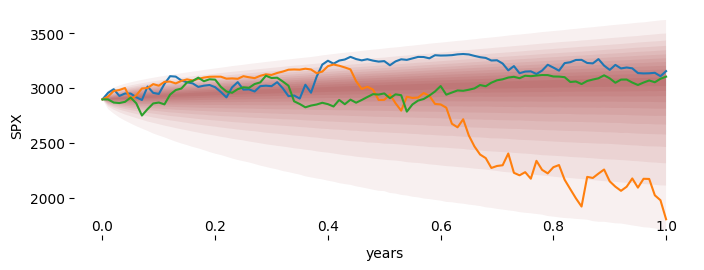

In [45]:
# Step 2: Initialize the Default Heston Model
model_default = HestonMC(dataset)

# Plot Asset Evolution (Default Dataset)
plot_asset(model_default, asset_name)

### Evolution of the asset.

In [46]:
# Step 3: Modify the Dataset for Different LONG_VAR Values
dataset1 = dataset.copy()
dataset1["HESTON"]["LONG_VAR"] = 0.04  # Default

dataset2 = dataset.copy()
dataset2["HESTON"]["LONG_VAR"] = 0.07  # Higher variance

# Initialize Models for Joy Plot
model1 = HestonMC(dataset1)
model2 = HestonMC(dataset2)


In [47]:
# Step 4: Generate Asset Paths for Joy Plot
times = np.linspace(0.2, 1.0, 5)

def generate_samples(model, times):
    all_prices = []
    all_times = []
    model.reset()
    for t in times:
        model.advance(t)
        prices = model.get_value(asset_name)
        all_prices.extend(prices)
        all_times.extend([f"t={t:4.2f}"] * len(prices))
    return pd.DataFrame({"values": all_prices, "time": all_times})

samples_df1 = generate_samples(model1, times)
samples_df2 = generate_samples(model2, times)

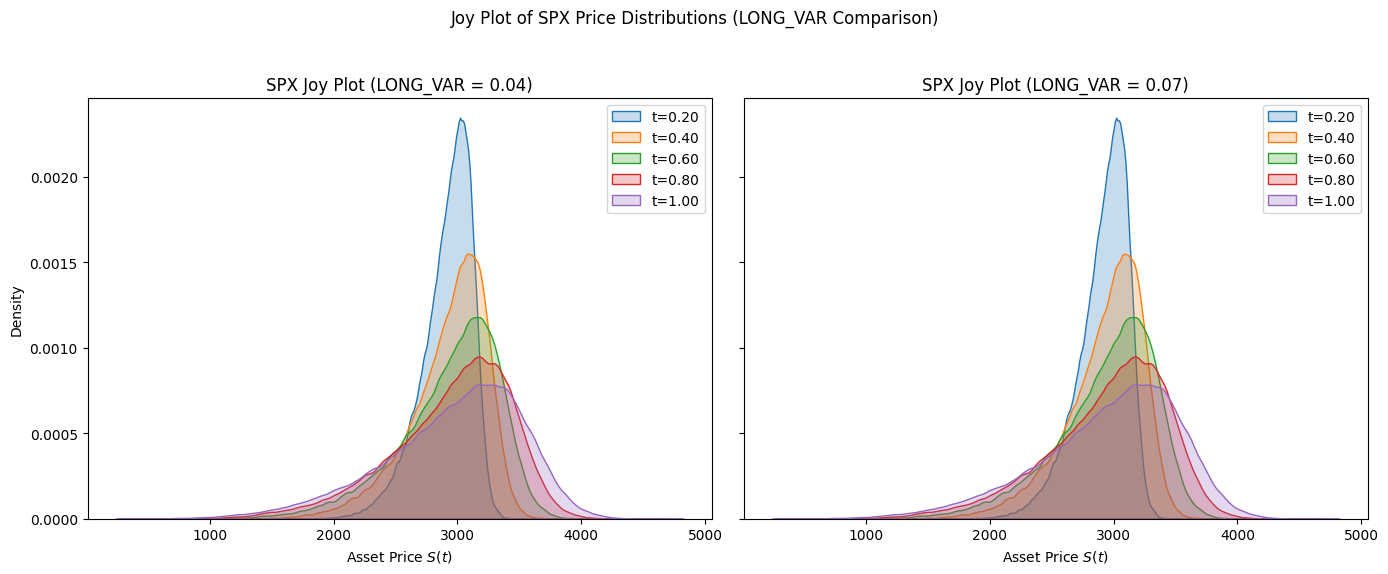

In [54]:
import seaborn as sns
# Step 5: Manually Overlay Joy Plots in Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
plt.suptitle(f"Joy Plot of {asset_name} Price Distributions (LONG_VAR Comparison)")

# Plot for LONG_VAR = 0.04
for t in times:
    sns.kdeplot(
        data=samples_df1[samples_df1['time'] == f"t={t:4.2f}"]['values'],
        ax=axes[0],
        fill=True,
        label=f"t={t:4.2f}",
        clip=(0, np.max(samples_df1['values'])),
        bw_adjust=0.5
    )
axes[0].set_xlabel("Asset Price $S(t)$")
axes[0].set_ylabel("Density")
axes[0].set_title(f"{asset_name} Joy Plot (LONG_VAR = 0.04)")
axes[0].legend()

# Plot for LONG_VAR = 0.07
for t in times:
    sns.kdeplot(
        data=samples_df2[samples_df2['time'] == f"t={t:4.2f}"]['values'],
        ax=axes[1],
        fill=True,
        label=f"t={t:4.2f}",
        clip=(0, np.max(samples_df2['values'])),
        bw_adjust=0.5
    )
axes[1].set_xlabel("Asset Price $S(t)$")
axes[1].set_title(f"{asset_name} Joy Plot (LONG_VAR = 0.07)")
axes[1].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<Figure size 700x600 with 0 Axes>

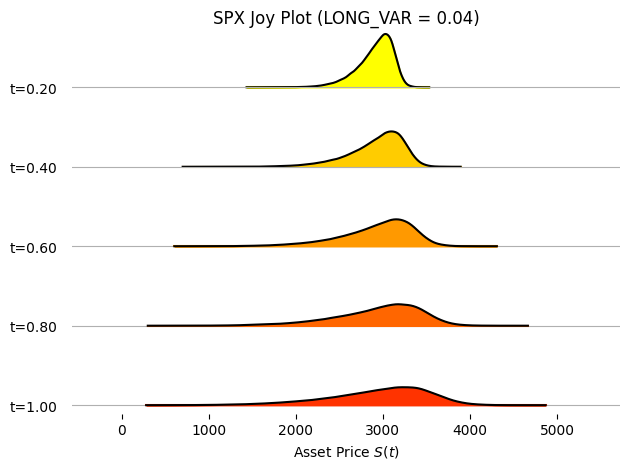

<Figure size 700x600 with 0 Axes>

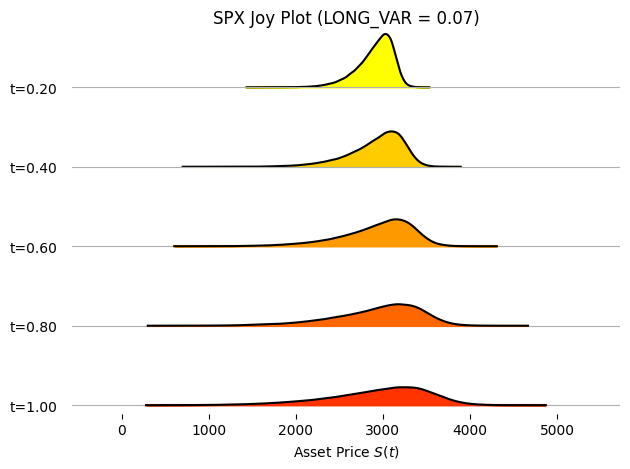

In [57]:
# Step 5: Create Two Separate Joy Plots Manually
fig1 = plt.figure(figsize=(7, 6))
joypy.joyplot(
    samples_df1,
    by="time",
    column="values",
    colormap=cm.autumn_r,
    kind="kde",
    range_style="own",
    grid="y",
    tails=1e-2,
)
plt.title(f"{asset_name} Joy Plot (LONG_VAR = 0.04)")
plt.xlabel("Asset Price $S(t)$")
plt.tight_layout()

fig2 = plt.figure(figsize=(7, 6))
joypy.joyplot(
    samples_df2,
    by="time",
    column="values",
    colormap=cm.autumn_r,
    kind="kde",
    range_style="own",
    grid="y",
    tails=1e-2,
)
plt.title(f"{asset_name} Joy Plot (LONG_VAR = 0.07)")
plt.xlabel("Asset Price $S(t)$")
plt.tight_layout()

# Adjust figure positions manually to simulate side-by-side layout
fig1.subplots_adjust(left=0.05, right=0.48, top=0.85)
fig2.subplots_adjust(left=0.52, right=0.95, top=0.85)

plt.show()